In [14]:
#Importing required Lbraries
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,7

In [15]:
#Loading dataset
amazon=web.DataReader('AMZN',data_source='yahoo',start='4/6/2016',end='4/6/2018',)
amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-04-06,602.390015,587.500000,587.520020,602.080017,2833500,602.080017
2016-04-07,599.599976,589.080017,598.760010,591.429993,3189000,591.429993
2016-04-08,597.859985,589.000000,594.320007,594.599976,2591900,594.599976
2016-04-11,604.000000,594.909973,596.140015,595.929993,2704300,595.929993
2016-04-12,604.059998,592.309998,598.400024,603.169983,2636300,603.169983


In [29]:
amazon.drop(columns=['High','Low','Close','Volume','Adj Close'],axis=1,inplace=True)

In [30]:
#inspecting table
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2016-04-06 to 2018-04-06
Data columns (total 1 columns):
Open    505 non-null float64
dtypes: float64(1)
memory usage: 7.9 KB


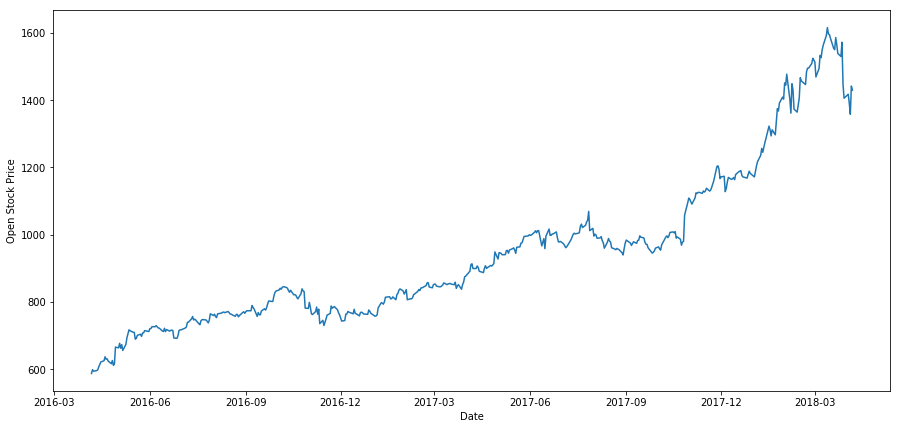

In [31]:
#plotting Open
plt.xlabel('Date')
plt.ylabel('Open Stock Price')
plt.plot(amazon)

In [32]:
#Checking rolling statistics 
rollmean=amazon.rolling(window=12).mean()
rollstd=amazon.rolling(window=12).std()
print(rollmean,rollstd)

                   Open
Date                   
2016-04-06          NaN
2016-04-07          NaN
2016-04-08          NaN
2016-04-11          NaN
2016-04-12          NaN
2016-04-13          NaN
2016-04-14          NaN
2016-04-15          NaN
2016-04-18          NaN
2016-04-19          NaN
2016-04-20          NaN
2016-04-21   611.941671
2016-04-22   615.020833
2016-04-25   616.508331
2016-04-26   619.162496
2016-04-27   620.467494
2016-04-28   621.895823
2016-04-29   626.755824
2016-05-02   630.826655
2016-05-03   635.446655
2016-05-04   638.549993
2016-05-05   641.564158
2016-05-06   643.734990
2016-05-09   647.314158
2016-05-10   653.108327
2016-05-11   660.539993
2016-05-12   668.140828
2016-05-13   676.710831
2016-05-16   684.593333
2016-05-17   688.251668
...                 ...
2018-02-23  1437.955841
2018-02-26  1442.972504
2018-02-27  1450.874166
2018-02-28  1463.042501
2018-03-01  1475.453328
2018-03-02  1482.384155
2018-03-05  1489.716654
2018-03-06  1495.242483
2018-03-07  1501

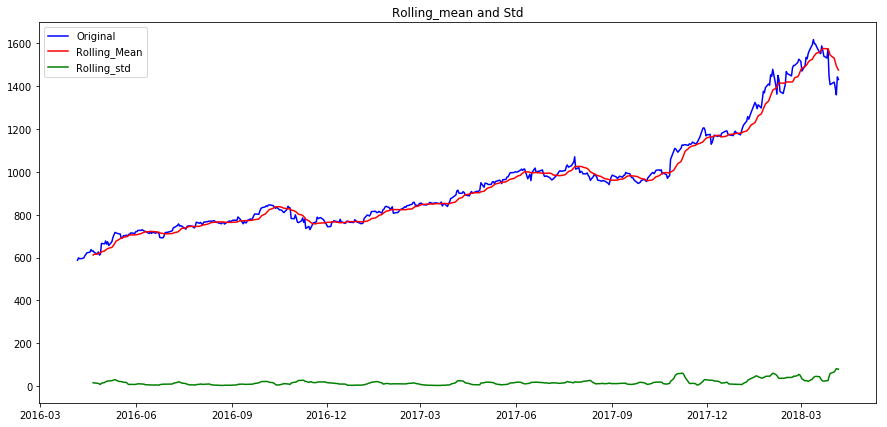

In [33]:
#plottin rolling data
original=plt.plot(amazon,color='blue',label='Original')
rollig_mean=plt.plot(rollmean,color='red',label='Rolling_Mean')
std=plt.plot(rollstd,color='green',label='Rolling_std')
plt.legend(loc='best')
plt.title('Rolling_mean and Std')
plt.show()

In [35]:
#Using Adfuller test to check for stationarity  of data
from statsmodels.tsa.stattools import adfuller
adfuller_test=adfuller(amazon['Open'])

adfuller_results = pd.Series(adfuller_test[0:4],index=['Statistics','P-value','lags used','Observations_used'])
print(adfuller_results)

Statistics            -0.054909
P-value                0.953749
lags used              3.000000
Observations_used    501.000000
dtype: float64


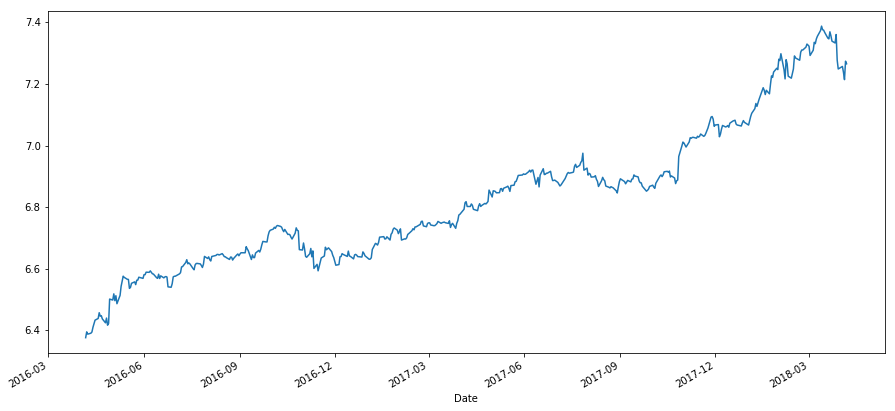

In [36]:
# As observed the P value is very high so we can not reject null hypothesis implying data is not stationary.
#Trend Estimation
amazon_log=np.log(amazon['Open'])
amazon_log.plot()

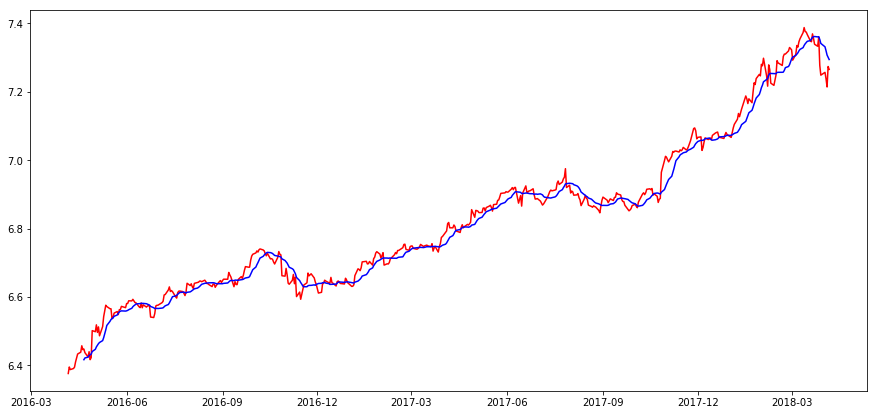

In [37]:
MovingAverage=amazon_log.rolling(window=12).mean()
Movingstd=amazon_log.rolling(window=12).std()
figure=plt.figure()
plt.plot(amazon_log,color='red')
plt.plot(MovingAverage,color='blue')
plt.show()

In [38]:
#We create a function for stationarity test
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    movingAv=timeseries.rolling(window=12).mean()
    movingstd=timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAv, color='red', label='Rolling Mean')
    std  = plt.plot(movingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    

In [42]:
#Time Series Transformation
log_minus_average=amazon_log-MovingAverage
log_minus_average.dropna(inplace=True)
log_minus_average.head()

Date
2016-04-21    0.031019
2016-04-22    0.015533
2016-04-25    0.000419
2016-04-26    0.011454
2016-04-27   -0.013924
Name: Open, dtype: float64

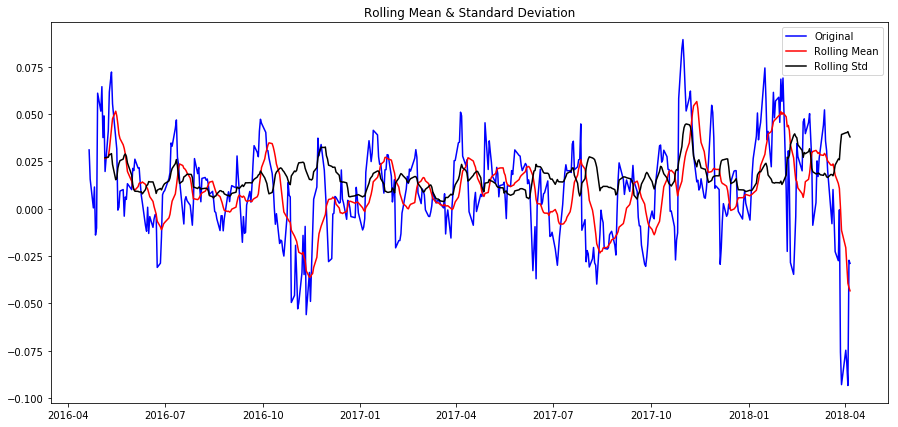

Results of Dickey-Fuller Test:
Test Statistic                -6.603525e+00
p-value                        6.643935e-09
#Lags Used                     0.000000e+00
Number of Observations Used    4.930000e+02
dtype: float64


In [43]:
stationarity_test(log_minus_average)
#From the results (p value <<< 0.05 ) we can now agree our model is stationary

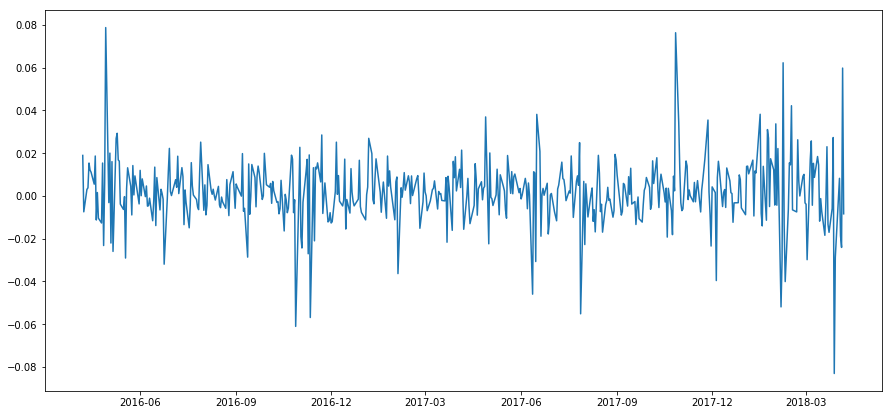

In [56]:
amazon_log_shift=amazon_log-amazon_log.shift()
plt.plot(amazon_log_shift)

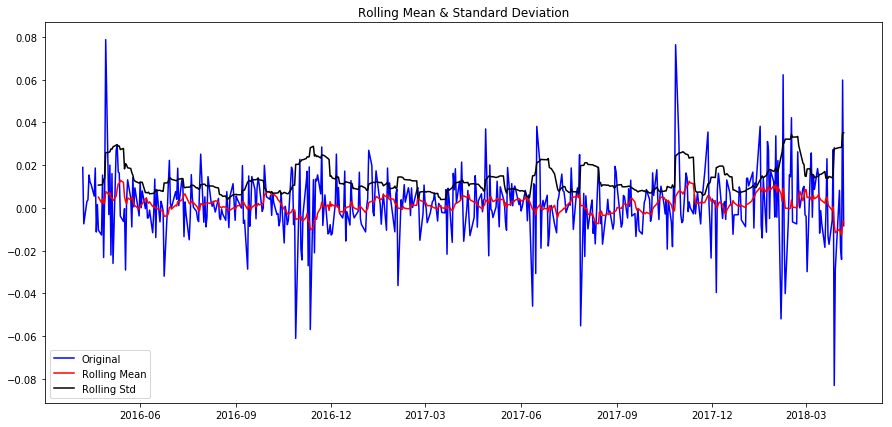

Results of Dickey-Fuller Test:
Test Statistic                -1.702623e+01
p-value                        8.387836e-30
#Lags Used                     1.000000e+00
Number of Observations Used    5.020000e+02
dtype: float64


In [57]:
amazon_log_shift.dropna(inplace=True)
stationarity_test(amazon_log_shift)

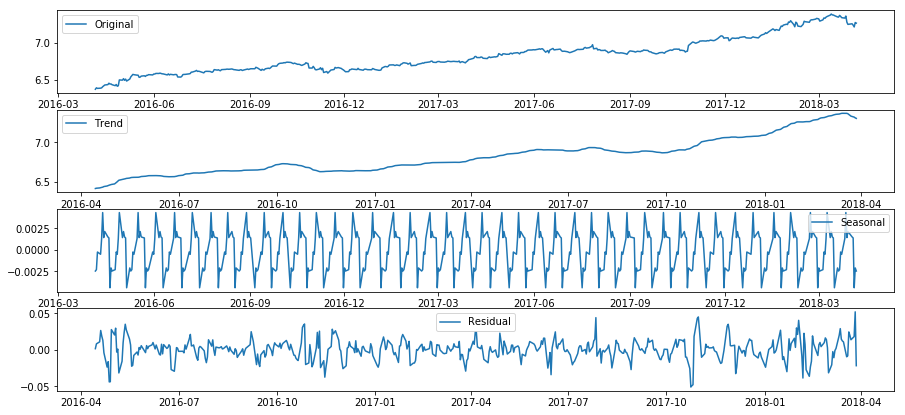

In [64]:
#Components of Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(amazon_log,freq=12)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(amazon_log,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')


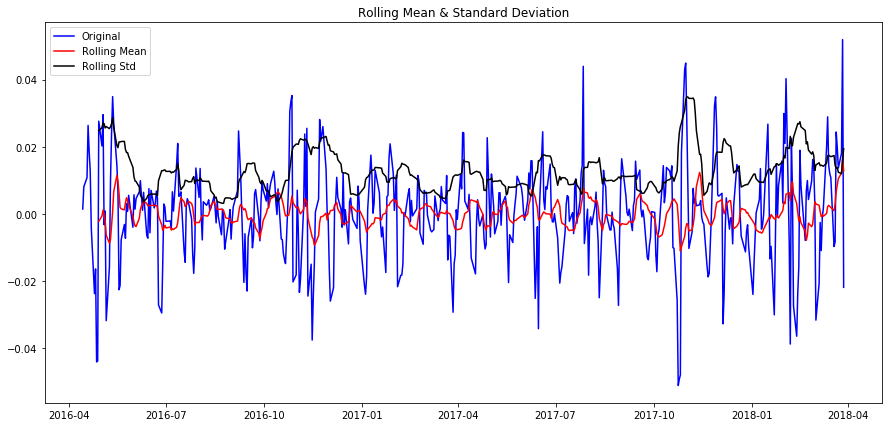

Results of Dickey-Fuller Test:
Test Statistic                -9.388586e+00
p-value                        6.655152e-16
#Lags Used                     1.300000e+01
Number of Observations Used    4.790000e+02
dtype: float64


In [67]:
#Analysing residuals or noise
amazon_decomposed_residuals=residual
amazon_decomposed_residuals.dropna(inplace=True)
stationarity_test(amazon_decomposed_residuals)